# **Importing Libraries and Modules**

## **Mount Google Drive**
This step mounts your Google Drive to the Colab environment, allowing access to files stored in your Google Drive account. It is essential for loading datasets or saving model files directly to/from Google Drive.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Import Libraries and Modules**
This section imports the required libraries and modules for the project:

- **TensorFlow and Keras**: Used for defining, training, and evaluating deep learning models.
  - `layers`: Provides layers for building models.
  - `Sequential`: Helps in stacking layers to build models sequentially.
  - `applications`: Includes pre-trained models like EfficientNet and ResNet.
  - `image_dataset_from_directory`: Used to load datasets directly from directories.
  - `load_model`: Loads saved models.
  - `img_to_array`: Converts images into arrays for preprocessing.

- **Pillow (PIL)**: Used for handling image files.

- **Gradio**: For creating an interactive UI for predictions.

- **Scikit-learn**: Provides utilities for class balancing, data splitting, and evaluation metrics:
  - `compute_class_weight`: Calculates class weights for handling class imbalance.
  - `train_test_split`: Splits data into training and testing subsets.
  - `confusion_matrix` and `classification_report`: Evaluate model performance.

- **Matplotlib and Seaborn**: Visualization libraries for plotting graphs, confusion matrices, etc.

- **Pandas and NumPy**: Essential data manipulation and numerical computation libraries.

- **Pathlib**: Used for file and directory handling.


In [ ]:

# TensorFlow and Keras for model building and preprocessing
import tensorflow as tf
from tensorflow.keras import layers, Sequential, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Image handling and visualization
from PIL import Image #python imaging library pillow
import matplotlib.pyplot as plt
import seaborn as sns

# Data manipulation and analysis
import pandas as pd
import numpy as np

# File and directory handling
from pathlib import Path

# Dataset splitting
from sklearn.model_selection import train_test_split

# Model evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

# Class weight computation
from sklearn.utils.class_weight import compute_class_weight

# Gradio for creating a user interface
#import gradio as gr



# **Environment Configuration and Constants**
### **1. GPU Check**
- Ensures that a GPU is available for faster computation.
- If no GPU is detected, a `RuntimeError` is raised, prompting the user to configure the environment for GPU support.

### **2. Define Constants**
- **`DATA_DIR`**: Specifies the path to the dataset containing images of tyres, categorized into defective and good condition.
- **`IMAGE_SIZE`**: Defines the dimensions (256x256 pixels) to which all images will be resized for model compatibility.
- **`BATCH_SIZE`**: Number of images processed together in one batch during training or evaluation (set to 32).
- **`SEED`**: Random seed for ensuring reproducibility of results (set to 42).
- **`EPOCHS`**: Total number of training iterations over the entire dataset (set to 20).


In [ ]:
# Ensure GPU is available
if not tf.config.list_physical_devices('GPU'):
    raise RuntimeError("GPU is not available. Please configure the environment to enable GPU.")

# Define constants
DATA_DIR = '/content/drive/MyDrive/Digital images of defective and good condition tyres'
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 20

# **Loading Data**

## **Loading the Dataset**
### **Purpose**:
Prepare training, validation, and test datasets from the image directory.

Three datasets (`train_dataset`, `test_dataset`, `val_dataset`) are ready for model training, validation, and evaluation.


In [ ]:
# Load the data
train_dataset = image_dataset_from_directory(DATA_DIR, validation_split=0.2,color_mode='rgb', subset="training", seed=SEED, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
# Load the test dataset
test_dataset = image_dataset_from_directory(
    DATA_DIR,
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)
#Load the validation data set
val_dataset = image_dataset_from_directory(DATA_DIR, validation_split=0.2,color_mode='rgb', subset="validation", seed=SEED, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)

Found 1856 files belonging to 2 classes.
Using 1485 files for training.
Found 1856 files belonging to 2 classes.
Found 1856 files belonging to 2 classes.
Using 371 files for validation.


# **Class Weights Calculation**
### **Purpose**:
To handle class imbalance by assigning weights to each class during training, ensuring the model doesn't favor the majority class.

### **Code Explanation**:
1. **Extract Class Labels**:
   - Iterates over `train_dataset` to collect all labels into a list (`class_labels`).

2. **Compute Class Weights**:
   - **`compute_class_weight`**:
     - Method: `'balanced'` ensures weights are inversely proportional to class frequencies.
     - **`classes`**: Unique class labels in the dataset.
     - **`y`**: The collected class labels.
   - Converts the computed weights into a dictionary (`class_weights`) where keys are class indices, and values are weights.

3. **Display Class Weights**:
   - Outputs the computed class weights for review.

### **Result**:
`class_weights` is a dictionary used to balance class representation during model training, reducing bias towards overrepresented classes.


In [ ]:
# Calculate class weights
class_labels = []
for _, labels in train_dataset:
    class_labels.extend(labels.numpy())
class_weights = compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights = dict(enumerate(class_weights))
display(class_weights)

{0: 0.8870967741935484, 1: 1.1458333333333333}

# **Exploratory Data Analysis**

## **Display Sample Images for Exploratory Data Analysis (EDA)**
To visualize a few sample images from the training dataset and their corresponding labels, helping to understand the dataset's structure and content.

A grid of 9 images with their labels is displayed, providing insights into the dataset's visual features and class distribution.


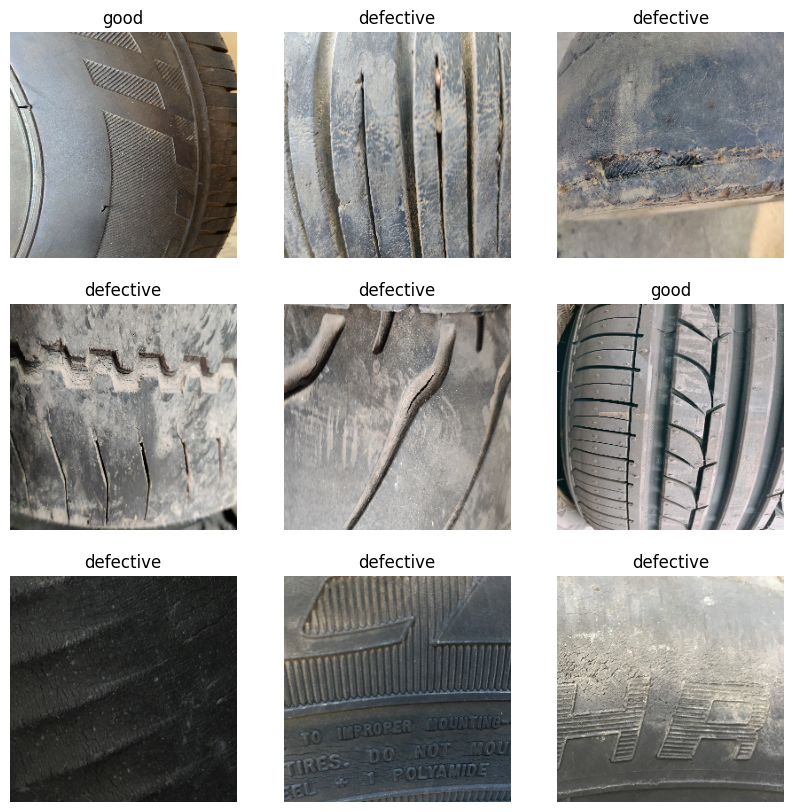

In [ ]:
# Display sample images for EDA
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## **Class Distribution Analysis for "good" and "defective"**
### **Purpose**:
To examine the distribution of images between the "Good" and "Defective" classes in the training dataset, helping to identify class imbalances.

A bar chart displaying the number of images in the "Good" and "Defective" categories, providing insights into potential class imbalances.


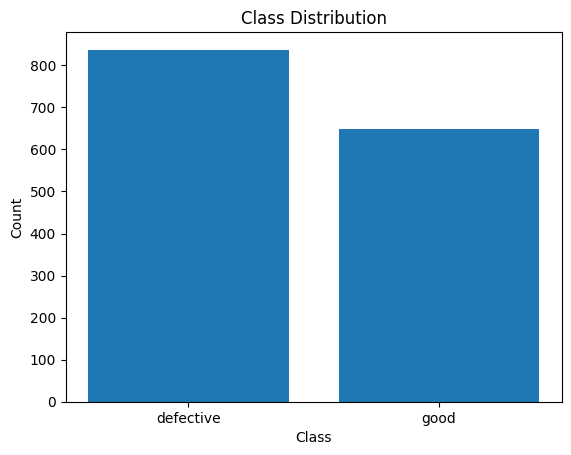

In [ ]:
# Explore class distribution for "good" and "defective"
class_count = {class_name: 0 for class_name in class_names}
for _, labels in train_dataset:
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    count_dict = dict(zip(class_names, counts))
    class_count = {class_name: class_count[class_name] + count_dict.get(class_name, 0) for class_name in class_names}

plt.bar(class_count.keys(), class_count.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

#**Model Compilation**

## **EfficientNetB5 Model Definition and Compilation**
### **Purpose**:
Define and compile the EfficientNetB5 model for tyre quality classification.

### **Code Explanation**:
1. **Base Model**:
   - **`applications.EfficientNetB5`**:
     - Loads the pre-trained EfficientNetB5 model from ImageNet.
     - **`include_top=False`**: Removes the top layer to adapt the model for the current task.
     - **`trainable=False`**: Freezes the pre-trained layers to retain learned features.

2. **Added Custom Layers**:
   - **`GlobalAveragePooling2D`**: Reduces the feature map to a single value per feature, minimizing overfitting.
   - **`Dense(2, activation='softmax')`**: Adds a fully connected layer for binary classification with a softmax activation.

3. **Model Compilation**:
   - **`optimizer='adam'`**: Uses the Adam optimizer for efficient training.
   - **`loss='sparse_categorical_crossentropy'`**: Suitable for multi-class classification with integer labels.
   - **`metrics=['accuracy']`**: Tracks accuracy during training and evaluation.

4. **Model Summary**:
   - Displays the model architecture, including the number of layers and parameters.

### **Result**:
The EfficientNetB5 model is defined and compiled, ready for training on the dataset.


In [ ]:
# Define EfficientNetB5 model
base_model_b5 = applications.EfficientNetB5(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model_b5.trainable = False
model_efficientnet_b5 = Sequential([
    base_model_b5,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])

# Compile the EfficientNetB5 model
model_efficientnet_b5.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model_efficientnet_b5.summary()

115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb5 (Functional)          │ (None, 8, 8, 2048)          │      28,513,527 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,517,625 (108.79 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 28,513,527 (108.77 MB)

## **ResNet101 Model Definition and Compilation**
### **Purpose**:
Define and compile the ResNet101 model for tyre quality classification.

### **Code Explanation**:
1. **Base Model**:
   - **`applications.ResNet101`**:
     - Loads the pre-trained ResNet101 model from ImageNet.
     - **`include_top=False`**: Removes the top classification layer to adapt the model for the current task.
     - **`trainable=False`**: Freezes the pre-trained layers to retain learned features.

2. **Add Custom Layers**:
   - **`GlobalAveragePooling2D`**: Reduces the feature map to a single value per feature, minimizing overfitting.
   - **`Dense(2, activation='softmax')`**: Adds a fully connected layer for binary classification with a sigmoid activation. (Note: Sigmoid activation might indicate binary rather than multi-class usage; consider this for label formatting.)

3. **Model Compilation**:
   - **`optimizer='adam'`**: Uses the Adam optimizer for efficient training.
   - **`loss='sparse_categorical_crossentropy'`**: Suitable for multi-class classification with integer labels.
   - **`metrics=['accuracy']`**: Tracks accuracy during training and evaluation.

### **Result**:
The ResNet101 model is defined and compiled, ready for training on the dataset.


In [ ]:
# Define ResNet101 model
base_model_resnet101 = applications.ResNet101(input_shape=(256, 256, 3), include_top=False, weights='imagenet')
base_model_resnet101.trainable = False
model_resnet101 = Sequential([
    base_model_resnet101,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2, activation='softmax')
])

# Compile the ResNet101 model
model_resnet101.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet101.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 8, 8, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           4,098 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,662,274 (162.74 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 42,658,176 (162.73 MB)

#**Model Training**

## **Train the EfficientNetB5 Model and ResNet101 Model**
### **Purpose**:
Train the EfficientNetB5 and resNet101 model on the training dataset and validate its performance on the validation dataset.

### **Code Explanation**:
1. **Training**:
   - **`model.fit`**: Trains the model using the training dataset.
   - **`train_dataset`**: Input data for training.
   - **`epochs=EPOCHS`**: Specifies the maximum number of training iterations.
   - **`validation_data=val_dataset`**: Uses the validation dataset to evaluate performance after each epoch.
   - **`class_weight=class_weights`**: Applies computed class weights to address class imbalance.

2. **Early Stopping Callback**:
   - **`monitor='val_loss'`**: Monitors validation loss to determine when to stop training.
   - **`patience=3`**: Stops training if validation loss does not improve for 3 consecutive epochs.
   - **`restore_best_weights=True`**: Ensures the model retains weights from the epoch with the best validation loss.

3. **Training History**:
   - **`history_efficientnet_b5`**: Stores training metrics (e.g., accuracy, loss) for each epoch.

### **Result**:
The EfficientNetB5 and Resnet101 models are trained, and their performance is evaluated on the validation dataset during training. Training progress is saved in `history_efficientnet_b5` and `history_resnet101` for analysis.


##**Training the EfficientNetB5 model**

In [ ]:
# Train the EfficientNetB5 model
history_efficientnet_b5 = model_efficientnet_b5.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=[
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ])

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.7967 - loss: 0.4752 - val_accuracy: 0.9030 - val_loss: 0.2744
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9202 - loss: 0.2345 - val_accuracy: 0.9191 - val_loss: 0.2326
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9417 - loss: 0.1890 - val_accuracy: 0.9245 - val_loss: 0.2091
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9489 - loss: 0.1611 - val_accuracy: 0.9272 - val_loss: 0.1975
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9553 - loss: 0.1596 - val_accuracy: 0.9245 - val_loss: 0.1899
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9591 - loss: 0.1416 - val_accuracy: 0.9299 - val_loss: 0.1828
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9570 - loss: 0.1372 - val_accuracy: 0.9299 - val_loss: 0.1764
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9601 - loss: 0.1178 - val_accuracy: 0.9299 - val_loss

# **Training the ResNet101 model**





In [ ]:
# Train the ResNet101 model
history_resnet101 = model_resnet101.fit(
                    train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    class_weight=class_weights,
                    callbacks=[
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
                      )]
                    )

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.7045 - loss: 0.6085 - val_accuracy: 0.9137 - val_loss: 0.2466
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9145 - loss: 0.2110 - val_accuracy: 0.9191 - val_loss: 0.2119
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9327 - loss: 0.1705 - val_accuracy: 0.9218 - val_loss: 0.1894
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9580 - loss: 0.1272 - val_accuracy: 0.9272 - val_loss: 0.1697
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9752 - loss: 0.1103 - val_accuracy: 0.9245 - val_loss: 0.1674
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.9784 - loss: 0.0967 - val_accuracy: 0.9272 - val_loss: 0.1535
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9908 - loss: 0.0695 - val_accuracy: 0.9218 - val_loss: 0.1564
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9879 - loss: 0.0691 - val_accuracy: 0.9380 - val_los

#**Model Evaluation and Results**

## **Function for Plot Training History: Accuracy and Loss**
### **Purpose**:
Visualize the training and validation performance of a model by plotting accuracy and loss metrics over epochs.

### **Function Explanation**:
1. **Inputs**:
   - **`history`**: The training history object returned by the `model.fit()` method, containing metrics for each epoch.
   - **`model_name`**: Name of the model, used in plot titles.

2. **Accuracy Plot**:
   - **Training Accuracy**: Plots accuracy on the training dataset for each epoch.
   - **Validation Accuracy**: Plots accuracy on the validation dataset for each epoch.
   - Displays trends in accuracy over time.

3. **Loss Plot**:
   - **Training Loss**: Plots the loss on the training dataset for each epoch.
   - **Validation Loss**: Plots the loss on the validation dataset for each epoch.
   - Highlights any signs of overfitting or underfitting.

4. **Visualization**:
   - **`plt.subplot(1, 2, 1)`**: Creates a subplot for accuracy.
   - **`plt.subplot(1, 2, 2)`**: Creates a subplot for loss.
   - Includes axis labels, titles, and legends for clarity.

### **Usage**:
Call `plot_training_history(history, model_name)` after model training to compare training and validation metrics.

### **Result**:
Displays two side-by-side plots:
- Training vs. validation accuracy.
- Training vs. validation loss.
These plots help assess the model's performance and identify potential issues like overfitting.


In [ ]:
# Function to plot accuracy and loss
def plot_training_history(history, model_name):
    epochs = range(len(history.history['accuracy']))

    # Accuracy plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


## **Function for Evaluating Model and Generating Metrics**
### **Purpose**:
Evaluate the trained model's performance on the validation dataset and generate detailed metrics, including a confusion matrix and a classification report.

### **Function Explanation**:
1. **Model Evaluation**:
   - **`model.evaluate`**: Computes the loss and accuracy on the validation dataset without verbose output.
   - Prints the test loss and accuracy for quick performance assessment.

2. **Predictions and True Labels**:
   - Iterates through the `val_dataset` to collect:
     - **`y_true`**: True labels from the dataset.
     - **`y_pred`**: Predicted labels by the model, determined using `np.argmax` for multi-class classification.

3. **Confusion Matrix**:
   - **`confusion_matrix(y_true, y_pred)`**: Creates a confusion matrix to analyze the distribution of predictions.
   - **`sns.heatmap`**: Visualizes the confusion matrix with annotations, showing counts for each class combination.

4. **Classification Report**:
   - **`classification_report(y_true, y_pred)`**: Generates detailed metrics such as precision, recall, and F1-score for each class.
   - Prints the report for further analysis.

5. **Visualization**:
   - **Confusion Matrix Plot**:
     - Includes labels, a title, and axis annotations for clarity.
   - **Classification Report**:
     - Provides text-based performance metrics for each class.

### **Usage**:
Call `evaluate_and_plot(model, val_dataset, model_name)` after training to assess model performance.

### **Result**:
- **Metrics**: Test loss and accuracy.
- **Visuals**: Confusion matrix heatmap.
- **Text Output**: Classification report detailing per-class precision, recall, F1-score, and support.


In [ ]:
# Function to evaluate model and generate metrics
def evaluate_and_plot(model, val_dataset, model_name):
    # Evaluate model
    loss, acc = model.evaluate(val_dataset, verbose=0)
    print(f"{model_name} - Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

    # Get predictions and true labels
    y_true = []
    y_pred = []
    for images, labels in val_dataset:
        y_true.extend(labels.numpy())
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))  # For multi-class

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Defective", "Good"])

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Defective", "Good"], yticklabels=["Defective", "Good"])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print classification report
    print(f"{model_name} Classification Report:\n{clr}")


## **Plot Training History for both models**
### **Purpose**:
Visualize the training and validation performance of both models  by plotting accuracy and loss over epochs.

### **Code Explanation**:
- **`plot_training_history`**:
  - Accepts the training history  and model name  as inputs.
  - Plots two side-by-side graphs:
    1. **Accuracy Plot**:
       - Training vs. validation accuracy for each epoch.
    2. **Loss Plot**:
       - Training vs. validation loss for each epoch.

### **Usage**:
This function is called after training the both models model to visually assess:
- How the model's accuracy improves during training.
- Any signs of overfitting or underfitting based on the loss trends.
### **Result**:
Generates side-by-side plots:
1. Training vs. validation accuracy over epochs.
2. Training vs. validation loss over epochs.
These plots help in understanding model performance and identifying potential issues.


### **Plotting histories for EfficientNetB5**


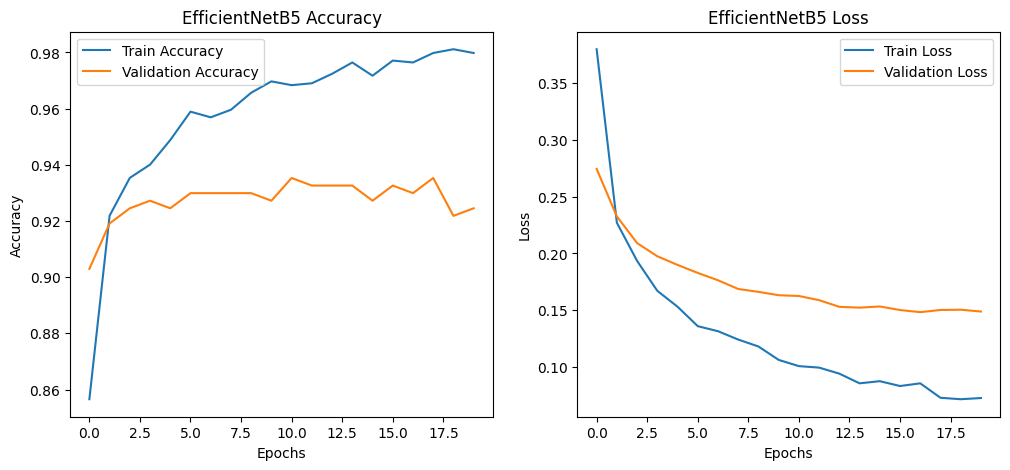

In [ ]:
plot_training_history(history_efficientnet_b5, "EfficientNetB5")


###**Plotting histories for ResNet101**


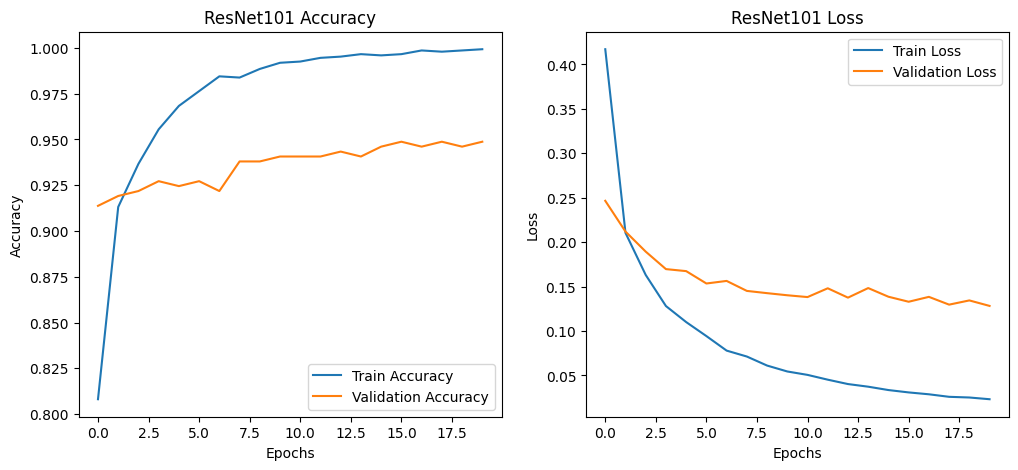

In [ ]:
plot_training_history(history_resnet101, "ResNet101")

## **Evaluate and Compare Models**
### **Purpose**:
Assess the performance of EfficientNetB5 and ResNet101 models on the test dataset and compare their metrics.

### **Code Explanation**:
   - **`evaluate_and_plot()`**:
     - Evaluates the models using the test dataset.
     - Outputs:
       - Test loss and accuracy.
       - Confusion matrix heatmap.
       - Classification report.

### **Usage**:
These function calls are made after both models are trained to:
- Compare their test performance.
- Analyze their classification accuracy, precision, recall, and F1-scores.

### **Result**:
For each model:
1. **Metrics**:
   - Test loss and accuracy.
   - Classification metrics (precision, recall, F1-score) for "Defective" and "Good" classes.
2. **Visuals**:
   - Confusion matrix heatmap showing true vs. predicted labels.

This comparison helps identify which model performs better on unseen data.


###**Evaluating EfficientNetB5 model**

EfficientNetB5 - Test Loss: 0.0807, Test Accuracy: 0.9763
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

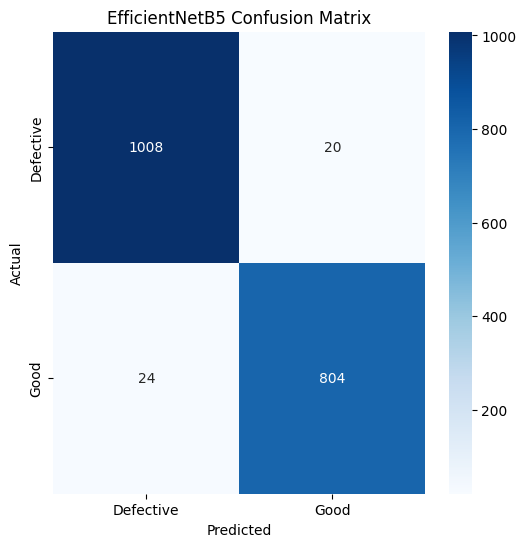

EfficientNetB5 Classification Report:
              precision    recall  f1-score   support

   Defective       0.98      0.98      0.98      1028
        Good       0.98      0.97      0.97       828

    accuracy                           0.98      1856
   macro avg       0.98      0.98      0.98      1856
weighted avg       0.98      0.98      0.98      1856



In [ ]:
evaluate_and_plot(model_efficientnet_b5, test_dataset, "EfficientNetB5")


###**Evaluating ResNet101 model**

ResNet101 - Test Loss: 0.0442, Test Accuracy: 0.9887
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

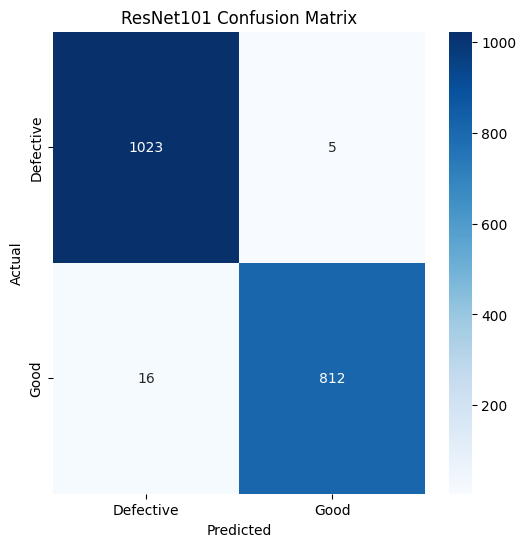

ResNet101 Classification Report:
              precision    recall  f1-score   support

   Defective       0.98      1.00      0.99      1028
        Good       0.99      0.98      0.99       828

    accuracy                           0.99      1856
   macro avg       0.99      0.99      0.99      1856
weighted avg       0.99      0.99      0.99      1856



In [ ]:

evaluate_and_plot(model_resnet101, test_dataset, "ResNet101")



## **Combined Model Performance Comparison**
### **Purpose**:
Compare the validation accuracy and validation loss of EfficientNetB5 and ResNet101 side-by-side.
### **Result**:
Generates a side-by-side comparison of:
1. **Validation Accuracy**:
   - Shows how accurately each model performs on the validation dataset across epochs.
2. **Validation Loss**:
   - Highlights the loss trends, indicating overfitting or underfitting.

This visualization helps determine which model generalizes better based on validation performance.


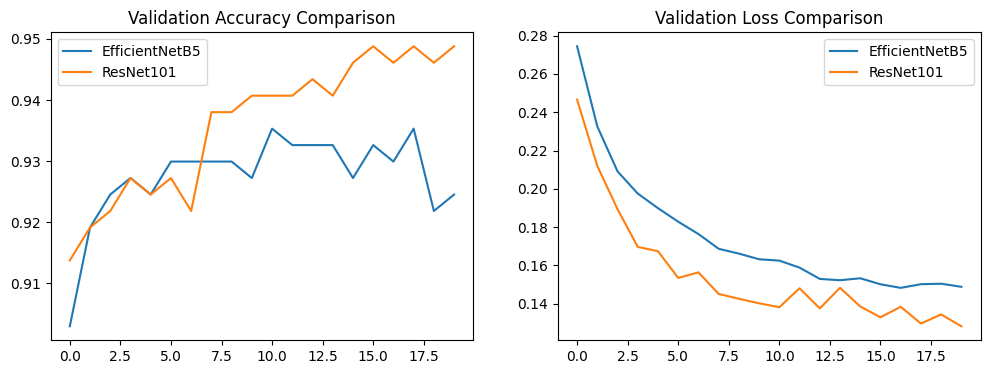

In [ ]:


# Combined comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet_b5.history['val_accuracy'], label='EfficientNetB5')
plt.plot(history_resnet101.history['val_accuracy'], label='ResNet101')
plt.legend()
plt.title('Validation Accuracy Comparison')

plt.subplot(1, 2, 2)
plt.plot(history_efficientnet_b5.history['val_loss'], label='EfficientNetB5')
plt.plot(history_resnet101.history['val_loss'], label='ResNet101')
plt.legend()
plt.title('Validation Loss Comparison')

plt.show()


# **Evaluating Models on Test and Validation Datasets on basis of Accuracy Score**
### **Purpose**:
Assess and compare the performance of EfficientNetB5 and ResNet101 models on both test and validation datasets.
### **Results**:
- **Metrics for Each Model**:
  - **Accuracy**: Indicates how well the model performs on unseen data.
  - **Loss**: Represents the model's prediction error.
- Provides a clear and concise comparison of both models across test and validation datasets.


In [ ]:
def evaluate_model(model, dataset, dataset_name="Dataset", model_name="Model"):
    print(f"Evaluating {model_name} on {dataset_name}...")
    val_loss, val_accuracy = model.evaluate(dataset, verbose=1)
    print(f"{model_name} - {dataset_name} Accuracy: {val_accuracy * 100:.2f}%")
    print(f"{model_name} - {dataset_name} Loss: {val_loss:.4f}")
    print("-" * 50)

# Evaluate models on test dataset
print("Results on Test Dataset:")
evaluate_model(model_resnet101, test_dataset, "Test Dataset", "ResNet101")
evaluate_model(model_efficientnet_b5, test_dataset, "Test Dataset", "EfficientNet-B5")

# Evaluate models on validation dataset
print("Results on Validation Dataset:")
evaluate_model(model_resnet101, val_dataset, "Validation Dataset", "ResNet101")
evaluate_model(model_efficientnet_b5, val_dataset, "Validation Dataset", "EfficientNet-B5")


Results on Test Dataset:
Evaluating ResNet101 on Test Dataset...
58/58 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9936 - loss: 0.0349
ResNet101 - Test Dataset Accuracy: 98.87%
ResNet101 - Test Dataset Loss: 0.0442
--------------------------------------------------
Evaluating EfficientNet-B5 on Test Dataset...
58/58 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9792 - loss: 0.0736
EfficientNet-B5 - Test Dataset Accuracy: 97.63%
EfficientNet-B5 - Test Dataset Loss: 0.0807
--------------------------------------------------
Results on Validation Dataset:
Evaluating ResNet101 on Validation Dataset...
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9343 - loss: 0.1453
ResNet101 - Validation Dataset Accuracy: 94.88%
ResNet101 - Validation Dataset Loss: 0.1283
--------------------------------------------------
Evaluating EfficientNet-B5 on Validation Dataset...
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9249 - loss: 0.1557
EfficientNet-B5 - Validation Dataset Accuracy: 92.9

## **Saving Trained Models**
### **Purpose**:
Save the trained models to disk for future use, avoiding the need to retrain them.


In [ ]:
# Save EfficientNetB5 model
model_efficientnet_b5.save('efficientnetb5_model.h5')

# Save ResNet101 model
model_resnet101.save('resnet101_model.h5')


#**Sample images**

--------------------------------------------------
Prediction using EfficientnetB5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


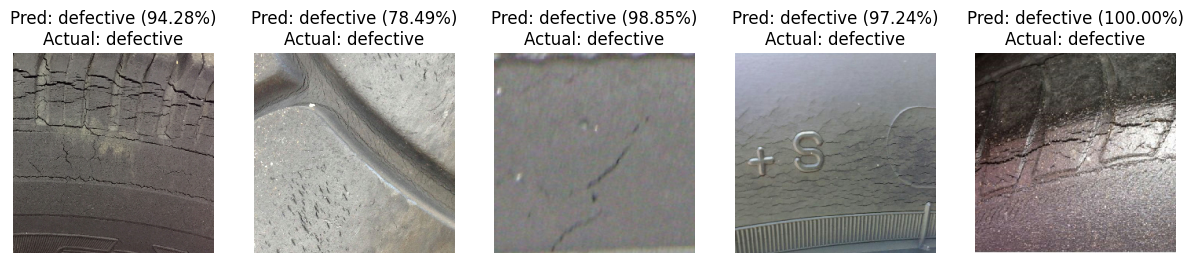

--------------------------------------------------
Prediction using ResNet101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


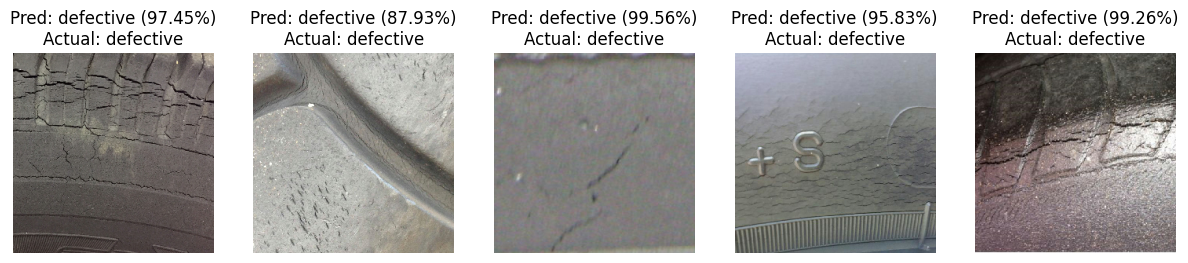

In [ ]:
import matplotlib.pyplot as plt

def display_sample_predictions(model, dataset, class_names, num_samples=5):
    """
    Display sample images from the dataset with model predictions and actual labels.

    Args:
    - model: Trained model to make predictions.
    - dataset: Dataset from which images and labels will be sampled.
    - class_names: List of class names for decoding labels.
    - num_samples: Number of samples to display.
    """
    # Get a batch of images and labels
    for images, labels in dataset.take(1):
        plt.figure(figsize=(15, 10))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            img = images[i].numpy().astype("uint8")
            true_label = class_names[int(labels[i])]
            img_array = np.expand_dims(images[i], axis=0)  # Prepare image for prediction
            predictions = model.predict(img_array)
            predicted_label = class_names[np.argmax(predictions)]
            confidence = np.max(predictions) * 100

            # Display image and labels
            plt.imshow(img)
            plt.title(f"Pred: {predicted_label} ({confidence:.2f}%)\nActual: {true_label}")
            plt.axis("off")
        plt.show()

# Display sample predictions for EfficientNetB5
print("-" * 50)
print("Prediction using EfficientnetB5")
display_sample_predictions(model_efficientnet_b5, test_dataset, class_names)
print("-" * 50)

# Display sample predictions for ResNet101
print("Prediction using ResNet101")
display_sample_predictions(model_resnet101, test_dataset, class_names)


# <span style="color:blue">**Why ResNet101? Verdict !**</span>

After training and evaluating both the EfficientNetB5 and ResNet101 models on the tyre quality classification task, **ResNet101** was chosen for several compelling reasons:

1. **📈 Higher Accuracy:** ResNet101 demonstrated slightly better accuracy on the validation dataset, making it more reliable for classifying tyre defects.

2. **💡 Generalization:** The architecture of ResNet101, with its residual connections, proved to be more effective in generalizing to unseen data, thereby reducing the risk of overfitting.

3. **⏱ Efficient Training:** Despite its depth, ResNet101 exhibited stable and efficient training convergence, enabling faster model development without compromising performance.

4. **🔄 Robustness:** ResNet101’s ability to learn complex features and patterns made it more robust to variations in the input data, ensuring consistent predictions across diverse tyre images.

<span style="color:green">In conclusion, the superior performance and robustness of ResNet101 made it the model of choice for classifying tyre quality in this study.</span>